In [1]:
import os
import sys
import re
import tarfile
from pathlib import Path
from six.moves import urllib

class InceptionModelDownloader:
    def __init__(self, url=None, path=None, class_label_url=None, checkpoint_path=None):
        if url is None:
            tf_models_repo = 'http://download.tensorflow.org/models'
            url = os.path.join(tf_models_repo, 'inception_v3_2016_08_28.tar.gz')
        if path is None:
            repo_root_dir = os.path.join(Path.home(), 'workspace/machine-learning')
            path = os.path.join(repo_root_dir, 'pretrained-models/inception')
        if class_label_url is None:
            class_label_url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/inception/imagenet_class_names.txt'
        if checkpoint_path is None:
            checkpoint_path = os.path.join(path, 'inception_v3.ckpt')

        self.url = url
        self.path = path
        self.class_label_url = class_label_url
        self.checkpoint_path = checkpoint_path

    def _download_progress(self, count, block_size, total_size):
        percent = count * block_size * 100 // total_size
        sys.stdout.write('\rDownloading: {:2.2f}%'.format(percent))
        sys.stdout.flush()
        
    def fetch_inception_v3(self):
        if os.path.exists(self.checkpoint_path):
            return
        
        os.makedirs(self.path, exist_ok=True)

        tgz_path = os.path.join(self.path, 'inception_v3.tgz')
        urllib.request.urlretrieve(self.url, tgz_path, reporthook=self._download_progress)
        
        with tarfile.open(tgz_path) as inception_tgz:
            inception_tgz.extractall(path=self.path)
        os.remove(tgz_path)
    
    def load_class_labels(self):
        class_labels_path = os.path.join(self.path, 'imagenet_class_names.txt')
        if os.path.exists(class_labels_path) == False:
            urllib.request.urlretrieve(self.class_label_url, class_labels_path)

        with open(class_labels_path, 'rb') as file:
            content = file.read().decode('utf-8')
            # Regex mean
            # ^ is begging point. And % is end point.
            # ^n is that the sequence begin with n.
            # *$ is that the seuqnce end with any character without newline.
            # n{digits}{white-space}{any characters}{white-space}
            class_label_regex = re.compile(r'^n\d+\s+(.*)\s*$', re.M | re.U)
            return class_label_regex.findall(content)

In [2]:
model_fetcher = InceptionModelDownloader()
model_fetcher.fetch_inception_v3()

In [3]:
class_labels = ['background'] + model_fetcher.load_class_labels()

In [4]:
for label in class_labels[:20]:
    print(label)

background
tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus
brambling, Fringilla montifringilla
goldfinch, Carduelis carduelis
house finch, linnet, Carpodacus mexicanus
junco, snowbird
indigo bunting, indigo finch, indigo bird, Passerina cyanea
robin, American robin, Turdus migratorius
bulbul
jay
magpie


In [5]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

X = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 3], name='X')
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=len(class_labels), is_training=False)

predictions = end_points['Predictions']
saver = tf.train.Saver()

In [6]:
import cv2
import numpy as np

def normalize_rgb(img):
    normalized = img.astype(np.float32)
    normalized /= 255.0
    return 2 * normalized - 1

def load_test_sample(sample_path, resource_dir=None):
    if resource_dir is None:
        home_dir = Path.home()
        resource_dir = os.path.join(home_dir, 'workspace/machine-learning/resource/misc')
        sample_path = os.path.join(resource_dir, sample_path)

    height, width, n_channels = (299, 299, 3)

    src = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)
    src = cv2.resize(src, (width, height))
    return (src, normalize_rgb(src))

In [7]:
sample_paths = ['siberian_tiger.jpg',
                'alaskan_malamute.jpg',
                'bengal_tiger.jpg',
                'carribian_flamingo.jpg',
                'hibiscus_syriacus.jpg',
                'man_bus.jpg',
                'gnocchi.jpg',
                'desk_lamp.jpg',
                'incheon_airport.jpg',
                'linus_torvalds.jpg',
                'busan_port.jpg',
                'africa_baobabs.jpg',
                'macbook_air.jpg',
                'mars_viking_zoom.jpg',
                'keyboard.jpg',
                'cafe_espresso.jpg']
samples = []
sample_images = {}

for sample_path in sample_paths:
    src, normalized = load_test_sample(sample_path)
    samples.append(normalized)
    sample_images[sample_path] = (src, normalized)
    
X_test = np.stack(samples, axis=0)

with tf.Session() as sess:
    saver.restore(sess, model_fetcher.checkpoint_path)
    predictions_val = predictions.eval(feed_dict={X: X_test})

W0821 23:04:20.253019 140591600944960 deprecation.py:323] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0821 23:04:32.555666 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


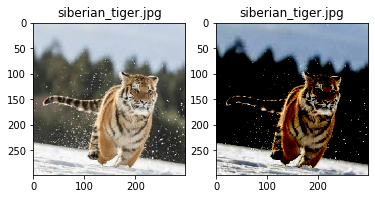

W0821 23:04:32.813355 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: siberian_tiger.jpg
tiger, Panthera tigris                       : 92.495%
tiger cat                                    : 3.656%
lynx, catamount                              : 0.206%
jaguar, panther, Panthera onca, Felis onca   : 0.067%




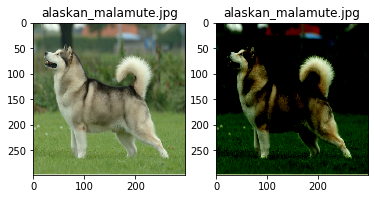

W0821 23:04:33.038197 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: alaskan_malamute.jpg
Norwegian elkhound, elkhound                 : 39.275%
malamute, malemute, Alaskan malamute         : 19.266%
Eskimo dog, husky                            : 12.303%
Siberian husky                               : 3.929%




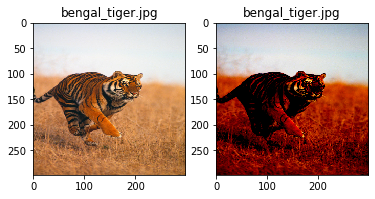

W0821 23:04:33.279040 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: bengal_tiger.jpg
tiger, Panthera tigris                       : 83.355%
tiger cat                                    : 9.075%
zebra                                        : 0.112%
lynx, catamount                              : 0.086%




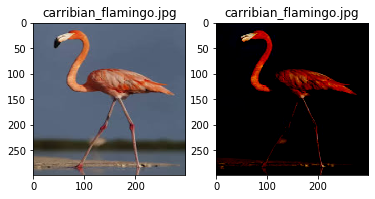

W0821 23:04:33.527193 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: carribian_flamingo.jpg
flamingo                                     : 87.701%
crane                                        : 0.212%
wardrobe, closet, press                      : 0.150%
American egret, great white heron, Egretta albus: 0.134%




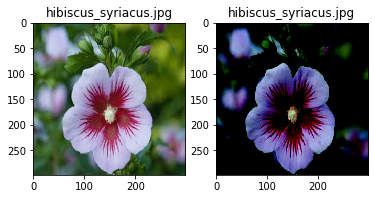

W0821 23:04:33.766649 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: hibiscus_syriacus.jpg
daisy                                        : 49.868%
earthstar                                    : 4.723%
pot, flowerpot                               : 3.741%
bee                                          : 3.445%




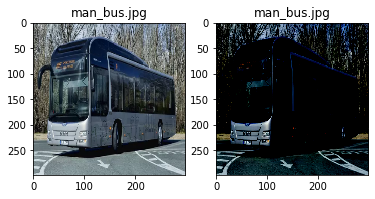

W0821 23:04:34.011229 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: man_bus.jpg
trolleybus, trolley coach, trackless trolley : 78.416%
passenger car, coach, carriage               : 7.835%
school bus                                   : 0.574%
minibus                                      : 0.294%




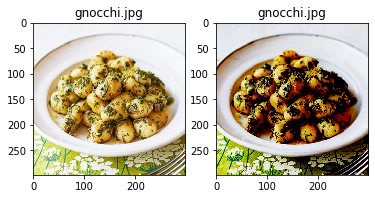

--------------------------------------------------------------------------------
label: gnocchi.jpg
bagel, beigel                                : 15.719%
pizza, pizza pie                             : 12.194%
French loaf                                  : 8.874%
plate                                        : 5.875%




W0821 23:04:34.223392 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


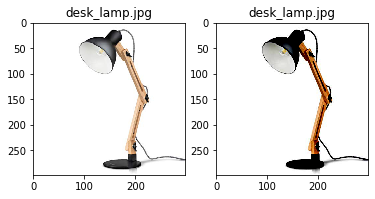

--------------------------------------------------------------------------------
label: desk_lamp.jpg
spotlight, spot                              : 98.336%
table lamp                                   : 1.367%
loudspeaker, speaker, speaker unit, loudspeaker system, speaker system: 0.050%
microphone, mike                             : 0.046%




W0821 23:04:34.516669 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


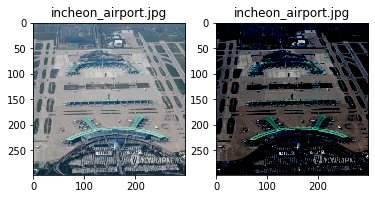

W0821 23:04:34.746096 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: incheon_airport.jpg
obelisk                                      : 14.879%
aircraft carrier, carrier, flattop, attack aircraft carrier: 7.174%
scoreboard                                   : 5.967%
maze, labyrinth                              : 4.349%




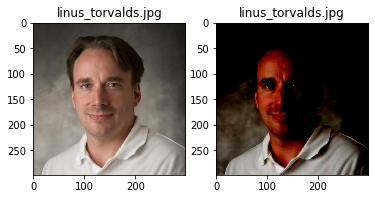

W0821 23:04:34.973595 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: linus_torvalds.jpg
lab coat, laboratory coat                    : 37.093%
oboe, hautboy, hautbois                      : 3.839%
bassoon                                      : 2.517%
Windsor tie                                  : 2.196%




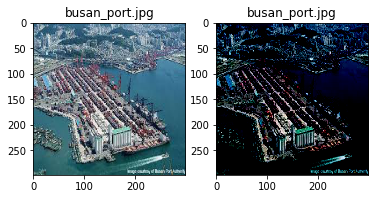

--------------------------------------------------------------------------------
label: busan_port.jpg
seashore, coast, seacoast, sea-coast         : 39.544%
promontory, headland, head, foreland         : 21.756%
lakeside, lakeshore                          : 19.453%
alp                                          : 2.487%




W0821 23:04:35.182290 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


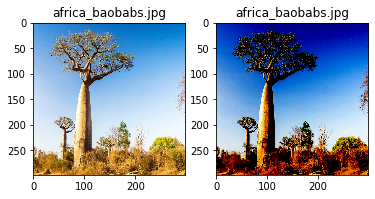

W0821 23:04:35.417507 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: africa_baobabs.jpg
obelisk                                      : 75.208%
megalith, megalithic structure               : 7.656%
maypole                                      : 0.664%
pole                                         : 0.474%




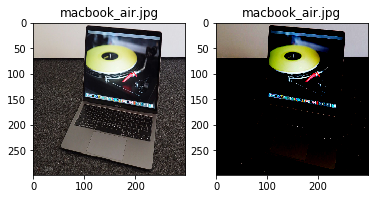

--------------------------------------------------------------------------------
label: macbook_air.jpg
notebook, notebook computer                  : 45.458%
laptop, laptop computer                      : 35.737%
iPod                                         : 1.552%
CD player                                    : 0.728%




W0821 23:04:35.621257 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


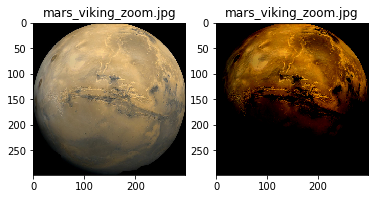

W0821 23:04:35.841332 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: mars_viking_zoom.jpg
croquet ball                                 : 22.265%
ping-pong ball                               : 13.269%
golf ball                                    : 10.137%
butternut squash                             : 6.150%




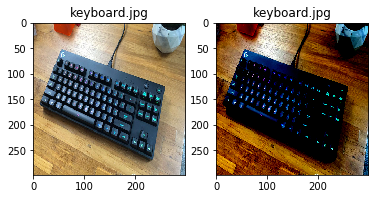

W0821 23:04:36.074515 140591600944960 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------
label: keyboard.jpg
computer keyboard, keypad                    : 85.665%
typewriter keyboard                          : 7.949%
space bar                                    : 2.398%
mouse, computer mouse                        : 0.336%




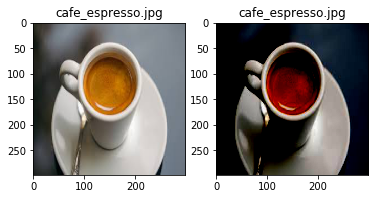

--------------------------------------------------------------------------------
label: cafe_espresso.jpg
espresso                                     : 74.077%
eggnog                                       : 2.243%
cup                                          : 1.937%
consomme                                     : 0.900%




In [9]:
import matplotlib.pyplot as plt

def show_sample_image(src, normalized, title):
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.set_title(title)
    ax1.set_title(title)
    ax0.imshow(src)
    ax1.imshow(normalized)
    plt.show()

top_5 = np.argsort(predictions_val, axis=1)[:,-1:-5:-1]
for sample_path, indice, prediction_probabilities in zip(sample_paths, top_5, predictions_val):
    source, normalized = sample_images[sample_path]
    show_sample_image(source, normalized, title=sample_path)
    print('-' * 80)
    print('label: {}'.format(sample_path))
    for idx in indice:
        print('{:45}: {:3.3f}%'.format(class_labels[idx], prediction_probabilities[idx] * 100))
    print('\n')